In [1]:
import os
from pathlib import Path

import geopandas as gpd
import matplotlib.pyplot as plt
from shapely.geometry import box

In [2]:
NE_COAST_PATH = "data/raw/ne_10m_coastline.shp"
NE_COUNTRIES_PATH = "data/raw/ne_10m_admin_0_countries.shp"
OUT_GPKG = "data/interim/singapore_coastline_3414.gpkg"
OUT_FIG = "figs/sg_coastline_extraction.png"

In [3]:
coast = gpd.read_file(NE_COAST_PATH)
countries = gpd.read_file(NE_COUNTRIES_PATH)

In [4]:
name_col = None
for c in ["NAME", "NAME_EN", "ADMIN", "SOVEREIGNT"]:
    if c in countries.columns:
        name_col = c
        break
if name_col is None:
    raise ValueError("Could not find a country name column in admin layer.")

In [5]:
sg = countries[countries[name_col].str.upper() == "SINGAPORE"].copy()

In [6]:
if sg.empty:
    iso_col = None
    for c in ["ADM0_A3", "ISO_A3", "ISO_A2"]:
        if c in countries.columns:
            iso_col = c
            break
    if iso_col is None:
        raise ValueError("Could not find SINGAPORE row in admin layer.")
    sg = countries[countries[iso_col].str.upper().isin(["SGP", "SG"])].copy()

if sg.empty:
    raise ValueError("Singapore polygon not found in admin layer.")

In [7]:
aoi_wgs84 = gpd.GeoDataFrame(geometry=[box(103.6, 1.16, 104.10, 1.47)], crs="EPSG:4326")
aoi_zoom = gpd.GeoDataFrame(geometry=[box(103.2, 0.9, 104.6, 1.8)], crs="EPSG:4326")

In [8]:
coast_regional = gpd.overlay(coast, aoi_zoom, how="intersection", keep_geom_type=True)

In [9]:
sg_3414 = sg.to_crs(epsg=3414)
sg_coastline_3414 = gpd.GeoDataFrame(geometry=sg_3414.geometry.boundary, crs=sg_3414.crs)

In [10]:
Path(OUT_GPKG).parent.mkdir(parents=True, exist_ok=True)
sg_coastline_3414.to_file(OUT_GPKG, layer="coast", driver="GPKG")

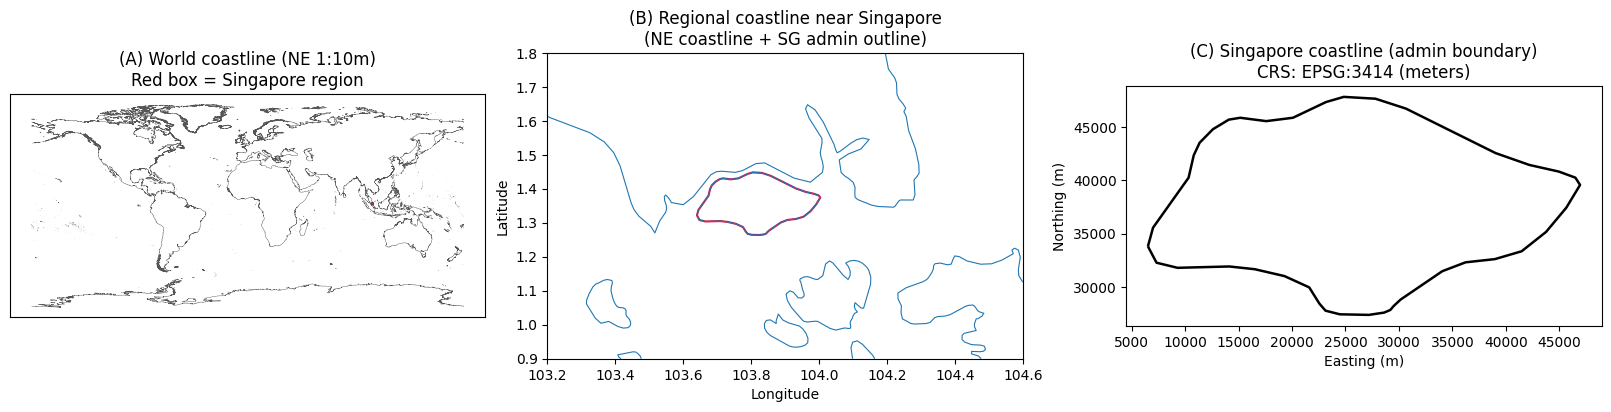

In [11]:
fig, axes = plt.subplots(1, 3, figsize=(16, 5), constrained_layout=True)

coast.plot(ax=axes[0], linewidth=0.3, color="#555555")
aoi_zoom.plot(ax=axes[0], facecolor="none", edgecolor="red", linewidth=1.5)
axes[0].set_title("(A) World coastline (NE 1:10m)\nRed box = Singapore region")
axes[0].set_xticks([])
axes[0].set_yticks([])

coast_regional.plot(ax=axes[1], linewidth=0.8, color="#1f77b4")
sg.plot(ax=axes[1], facecolor="none", edgecolor="crimson", linewidth=1.5)
axes[1].set_title(
    "(B) Regional coastline near Singapore\n(NE coastline + SG admin outline)"
)
axes[1].set_xlim(aoi_zoom.total_bounds[0], aoi_zoom.total_bounds[2])
axes[1].set_ylim(aoi_zoom.total_bounds[1], aoi_zoom.total_bounds[3])
axes[1].set_xlabel("Longitude")
axes[1].set_ylabel("Latitude")

sg_coastline_3414.plot(ax=axes[2], linewidth=1.8, color="black")
axes[2].set_title("(C) Singapore coastline (admin boundary)\nCRS: EPSG:3414 (meters)")
axes[2].set_xlabel("Easting (m)")
axes[2].set_ylabel("Northing (m)")
axes[2].set_aspect("equal")

In [12]:
for out_dir in [OUT_GPKG.split("/")[0], OUT_FIG.split("/")[0]]:
    if out_dir and not os.path.exists(out_dir):
        os.makedirs(out_dir, exist_ok=True)

plt.savefig(OUT_FIG, dpi=200)
plt.show()

print(f"[OK] Saved Singapore coastline to: {OUT_GPKG}")
print(f"[OK] Saved figure to: {OUT_FIG}")

<Figure size 640x480 with 0 Axes>

[OK] Saved Singapore coastline to: data/interim/singapore_coastline_3414.gpkg
[OK] Saved figure to: figs/sg_coastline_extraction.png
